In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torchvision.models import resnet34, ResNet34_Weights
from torch.utils.data import DataLoader, Sampler
from AdaIN import AdaIN

In [2]:
rn = resnet34(weights=ResNet34_Weights.DEFAULT)
print(rn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

#coco content
train_content_dataset = datasets.ImageFolder(
    root= "../coco",             
    transform=transform
)

#wikiart
train_style_dataset = datasets.ImageFolder(
    root= "../archive",             
    transform=transform
)

train_content_loader = DataLoader(train_content_dataset, batch_size=1, shuffle=True)
train_style_loader = DataLoader(train_style_dataset, batch_size=1, shuffle=True)

Epoch: 1
[1000/20000] content=2.7456 style=2.4673 total=5.212811
[2000/20000] content=2.3686 style=2.1148 total=4.483425
[3000/20000] content=2.2573 style=1.9924 total=4.249733
[4000/20000] content=2.1626 style=1.8798 total=4.042437
[5000/20000] content=2.1226 style=1.8167 total=3.939292
[6000/20000] content=2.1109 style=1.7831 total=3.894021
[7000/20000] content=2.0708 style=1.7234 total=3.794191
[8000/20000] content=2.0504 style=1.6897 total=3.740055
[9000/20000] content=1.9999 style=1.6314 total=3.631253
[10000/20000] content=2.0091 style=1.6298 total=3.638895
[11000/20000] content=1.9765 style=1.5896 total=3.566068
[12000/20000] content=1.9869 style=1.5906 total=3.577485
[13000/20000] content=1.9597 style=1.5523 total=3.512051
[14000/20000] content=1.9590 style=1.5499 total=3.508899
[15000/20000] content=1.9585 style=1.5438 total=3.502301
[16000/20000] content=1.9336 style=1.5101 total=3.443737
[17000/20000] content=1.9632 style=1.5301 total=3.493307
[18000/20000] content=1.8910 st

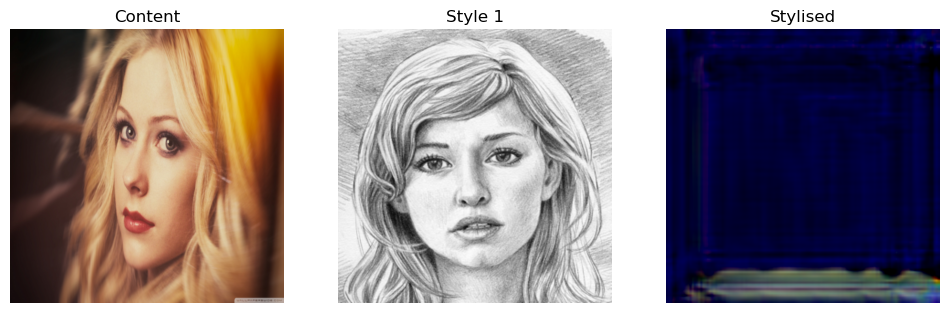

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.906, '359.175 ms')

In [4]:
style_path = "style/sketch.png"
image_path = "content/avril.jpg"

encoder = nn.Sequential(*list(rn.children())[:8])


decoder = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
    
        )

resnetModel = AdaIN()
resnetModel.uploadEncoder(encoder)
resnetModel.uploadDecoder(decoder)
resnetModel.epochTraining(train_content_loader, train_style_loader, "resnet34_layer4", steps = 20000, epoch = 5)
resnetModel.fit(image_path, [style_path])
resnetModel.pipeline()
resnetModel.displayImages()
resnetModel.evaluate()

Epoch: 1
[1000/20000] content=0.0509 style=0.0144 total=0.065301
[2000/20000] content=0.0465 style=0.0114 total=0.057892
[3000/20000] content=0.0455 style=0.0109 total=0.056440
[4000/20000] content=0.0452 style=0.0108 total=0.055979
[5000/20000] content=0.0442 style=0.0105 total=0.054680
[6000/20000] content=0.0437 style=0.0102 total=0.053942
[7000/20000] content=0.0436 style=0.0102 total=0.053821
[8000/20000] content=0.0432 style=0.0100 total=0.053222
[9000/20000] content=0.0431 style=0.0099 total=0.052985
[10000/20000] content=0.0432 style=0.0099 total=0.053140
[11000/20000] content=0.0420 style=0.0095 total=0.051471
[12000/20000] content=0.0421 style=0.0095 total=0.051621
[13000/20000] content=0.0423 style=0.0096 total=0.051850
[14000/20000] content=0.0418 style=0.0094 total=0.051231
[15000/20000] content=0.0421 style=0.0094 total=0.051514
[16000/20000] content=0.0418 style=0.0093 total=0.051089
[17000/20000] content=0.0414 style=0.0092 total=0.050591
[18000/20000] content=0.0415 st

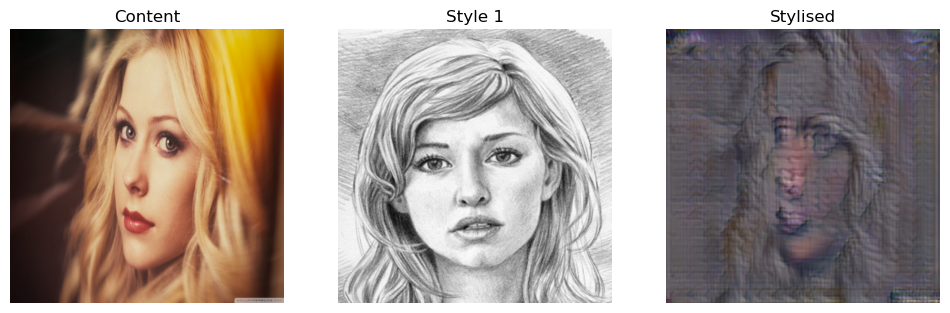

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.944, '1068.655 ms')

In [9]:
encoder_new = nn.Sequential(*list(rn.children())[:7])


decoder_new = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
    
        )

resnetModel2 = AdaIN()
resnetModel2.uploadEncoder(encoder_new)
resnetModel2.uploadDecoder(decoder_new)
resnetModel2.epochTraining(train_content_loader, train_style_loader, "resnet34_layer3", steps = 20000, epoch = 5)
resnetModel2.fit(image_path, [style_path])
resnetModel2.pipeline()
resnetModel2.displayImages()
resnetModel2.evaluate()

Epoch: 1
[1000/20000] content=0.0417 style=0.0075 total=0.049228
[2000/20000] content=0.0260 style=0.0046 total=0.030638
[3000/20000] content=0.0224 style=0.0042 total=0.026644
[4000/20000] content=0.0202 style=0.0042 total=0.024390
[5000/20000] content=0.0191 style=0.0040 total=0.023067
[6000/20000] content=0.0185 style=0.0040 total=0.022568
[7000/20000] content=0.0175 style=0.0039 total=0.021396
[8000/20000] content=0.0173 style=0.0038 total=0.021109
[9000/20000] content=0.0167 style=0.0038 total=0.020516
[10000/20000] content=0.0162 style=0.0037 total=0.019920
[11000/20000] content=0.0159 style=0.0036 total=0.019531
[12000/20000] content=0.0158 style=0.0038 total=0.019578
[13000/20000] content=0.0156 style=0.0036 total=0.019244
[14000/20000] content=0.0156 style=0.0038 total=0.019432
[15000/20000] content=0.0152 style=0.0036 total=0.018730
[16000/20000] content=0.0152 style=0.0037 total=0.018932
[17000/20000] content=0.0149 style=0.0036 total=0.018529
[18000/20000] content=0.0150 st

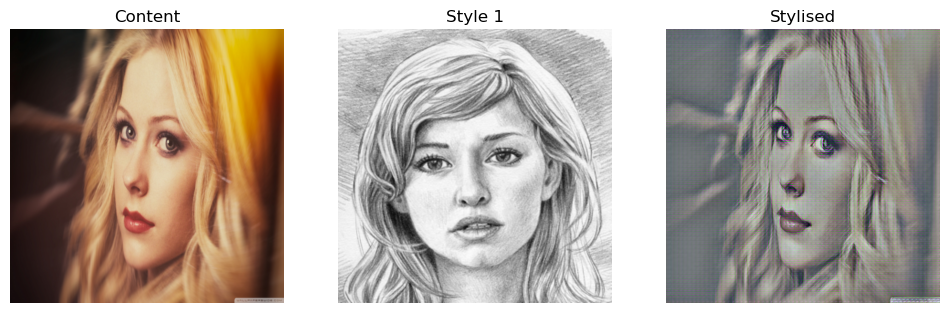

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.642, '416.302 ms')

In [12]:
encoder_2l = nn.Sequential(*list(rn.children())[:6])


decoder_2l = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
    
        )

resnetModel3 = AdaIN()
resnetModel3.uploadEncoder(encoder_2l)
resnetModel3.uploadDecoder(decoder_2l)
resnetModel3.epochTraining(train_content_loader, train_style_loader, "resnet34_layer2", steps = 20000, epoch = 5)
resnetModel3.fit(image_path, [style_path])
resnetModel3.pipeline()
resnetModel3.displayImages()
resnetModel3.evaluate()